In [1]:
from tsai.all import *
import os
import re
import shutil
import glob
import datetime
import time
import mne

import pandas as pd
import numpy as np
import numpy as np
import sklearn.metrics as skm
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
%matplotlib inline
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.7.13
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 1.12.1+cu116
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Physionet dataset preprocessing

In [2]:
dataset_path = r"D:\WORK\UMBC\CAP\physionet.org\files\capslpdb\1.0.0"

# read all edf files and store their path in a list
edf_files = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".edf"):
             edf_files.append(os.path.join(root, file))

edf_files[:5]

['D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\brux1.edf',
 'D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\brux2.edf',
 'D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\ins1.edf',
 'D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\ins2.edf',
 'D:\\WORK\\UMBC\\CAP\\physionet.org\\files\\capslpdb\\1.0.0\\ins3.edf']

In [3]:
# function to read .txt files and return a dataframe
def read_txt(file_path):
    with open(file_path, "r") as f:
        for line in f:
            if line.strip() == "Scoring Time:":
                break

        df = pd.read_csv(f, sep="\t")
        print("filename:", file_path.split("\\")[-1])
        print("Shape of dataframe:", df.shape)
        
    return df

In [6]:
def process_data(edf_file):
    print("Processing file:", edf_file.split("\\")[-1])
    
    # --- read edf file using mne --- #
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    
    # Define a list of channel names you want to keep
    selected_channels = ['Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'C4-A1']
    # Select the channels you want to keep
    raw.pick_channels(ch_names=selected_channels)
    print("New raw created successfully with EEG Ch only")

    # get info 
    info = raw.info
    channels = info["ch_names"]
    Fs = info["sfreq"]
    EpochTime = 1 # seconds

    # --- read annotations --- # 
    ann_df = read_txt(edf_file.replace(".edf", ".txt"))
    # non MCAP events are renamed as NonCAP and events starting with MCAP are kept as it is
    ann_df["Event"] = ann_df["Event"].apply(lambda x: "NonCAP" if x.startswith("MCAP") == False else x)

    # get the start and end time of ann_df dataframe
    start_ann_time, end_ann_time = ann_df["Time [hh:mm:ss]"].iloc[0], ann_df["Time [hh:mm:ss]"].iloc[-1]

    print("Start time of annotations:", start_ann_time)

    # convert start time to datetime format using EEG_data.info["meas_date"] date only
    start_ann_time = raw.info["meas_date"].replace(hour=int(re.split('(\d+)',start_ann_time)[1:-1][::2][0]),
                                                minute=int(re.split('(\d+)',start_ann_time)[1:-1][::2][1]),
                                                second=int(re.split('(\d+)',start_ann_time)[1:-1][::2][2]))

    # create annotations using mne.Annotations
    annotations = mne.Annotations(onset=ann_df["Duration[s]"].cumsum().to_list(),
                                duration=ann_df["Duration[s]"].to_list(),
                                description=ann_df["Event"].to_list(),
                                orig_time=start_ann_time)

    # add the annotations to the raw data
    raw.set_annotations(annotations=annotations)

    #--- removing non annotated data ---#
    # Create a list to store time intervals with annotations
    annotation_intervals = []

    for onset, duration, _ in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
        annotation_intervals.append((onset, onset + duration))

    if len(annotation_intervals) == raw.annotations.__len__():
        print("Annotation intervals created successfully")

    # Initialize an empty list to store data segments
    data_segments = []

    # Extract data segments corresponding to annotation intervals
    for onset, end in annotation_intervals:
        segment, times = raw[:, int(onset * Fs):int(end * Fs)]
        data_segments.append(segment)

    # Concatenate the data segments
    new_data = mne.io.RawArray(np.concatenate(data_segments, axis=1), raw.info)
    # Create a new Raw object with the concatenated data
    new_raw = mne.io.RawArray(new_data.get_data(), raw.info)

    # resample the data to 256 Hz
    new_raw.resample(256)

    # get a list from EEG_data.annotations dataframe such that it has shape of 'duration' * 'description' 
    new_label = raw.annotations.to_data_frame()['description'].to_list()

    new_label = [item for sublist in [[i] * int(j) for i, j in zip(new_label, raw.annotations.to_data_frame()['duration'].to_list())] for item in sublist]

    if new_raw.__len__() / 256 == len(new_label):
        print("New label created successfully")

        print("=" * 50)
        
        return new_raw, new_label # return rawData and labels list


##### Store all the data in list of dataframes

In [7]:
process_data(edf_files[3])[0].to_data_frame()

Processing file: ins2.edf
New raw created successfully with EEG Ch only
filename: ins2.txt
Shape of dataframe: (1929, 5)
Start time of annotations: 18:25:38
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=25712128
    Range : 0 ... 25712127 =      0.000 ... 50218.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=25712128
    Range : 0 ... 25712127 =      0.000 ... 50218.998 secs
Ready.
New label created successfully


,time,Fp2-F4,F4-C4,C4-P4,P4-O2,C4-A1
0,0.000000,-9.249225,-3.785086,3.876688,8.638839,6.103319
1,0.003906,-10.075369,-2.390456,4.574135,8.600593,15.324337
2,0.007812,-10.824716,-1.822769,4.046905,8.022854,14.662022
3,0.011719,-8.781735,-1.699229,3.030315,7.647402,14.451234
4,0.015625,-5.675409,-2.950534,1.469627,7.745394,6.612445
...,...,...,...,...,...,...
12856059,50218.980469,2.259798,0.574166,-1.068708,0.872669,-8.946356
12856060,50218.984375,7.661770,0.957571,0.161523,0.954665,-12.579795
12856061,50218.988281,12.248516,-0.317573,0.391343,1.330978,-17.637212
12856062,50218.992188,9.763125,-2.410577,0.211201,2.566608,-13.648842


### TSData preparation 3D array


In [9]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

# metrics = [accuracy_multi, RecallMulti(), PrecisionMulti(), FBetaMulti(beta=1, average='weighted')]


def train_and_evaluate_it(X, y, splits, bs, epochs):
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train,
                                   dsets.valid,
                                   bs=bs,
                                   batch_tfms=[TSStandardize()],
                                   num_workers=0)
    # model = build_ts_model(InceptionTimePlus, dls=dls, **{'fc_dropout': 0.5})
    model = build_ts_model(InceptionTimePlus, dls=dls)
    learn = Learner(dls, model, metrics=accuracy, loss_func=CrossEntropyLossFlat())
    learn.lr_find()
    learn.fit_one_cycle(epochs, lr_max=1e-1)
    learn.plot_metrics()
    learn.show_results(sharey=True)
    learn.show_probas()

    # Get predictions
    dls = learn.dls
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(
        dl=valid_dl, with_decoded=True)

    # Plot confusion matrix
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()

    # plot hypnogram of the predictions and the targets
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(valid_preds, label='Predictions')
    ax.plot(valid_targets, label='Targets')
    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Sleep Stage')
    ax.set_title('Validation Predictions vs Targets')
    plt.show()

def reshapper(X, y):
    # reshape the new_raw data into 2D array
    new_raw_arr = X.reshape(-1, 256, 5)
    new_raw_arr = new_raw_arr.transpose(0, 2, 1)

    # label encoding
    Label_encoding = {
                "NonCAP": 0,
                "MCAP-A1": 1,
                "MCAP-A2": 2,
                "MCAP-A3": 3,
    }

    labeler = ReLabeler(Label_encoding)

    X = new_raw_arr
    y = labeler(np.array(y))

    return X, y

def get_train_valid_splits(edf_files_paths):

    for i, curr_path in enumerate(edf_files_paths):
        # select all other datafrmes from data list except the current one
        l = [process_data(edf_file) for edf_file in edf_files_paths if edf_file is not curr_path]
        m = process_data(curr_path)

        # concatenate all mne raw objects and labels
        X_train = np.concatenate([i[0].get_data() for i in l], axis=1)
        X_valid = m[0].get_data()
        
        y_train = np.concatenate([i[1] for i in l])
        y_valid = m[1]

        # reshape the data
        X_train, y_train = reshapper(X_train, y_train)
        X_valid, y_valid = reshapper(X_valid, y_valid)

        display(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
        label_counts = collections.Counter(y_train)
        print('Counts by label:', dict(label_counts))
        print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

        X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
        display(splits)
        
        # delete the variables to free up memory
        del X_train, X_valid, y_train, y_valid, label_counts

        # train this fold 
        train_and_evaluate_it(X, y, splits, [64, 128], 10)

        # delete the variables to free up memory
        del X, y, splits

        print("=" * 50)
        print("=" * 50)

        

### InceptionTime model definition

Processing file: ins1.edf
New raw created successfully with EEG Ch only
filename: ins1.txt
Shape of dataframe: (1225, 5)
Start time of annotations: 22:30:28
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=7848960
    Range : 0 ... 7848959 =      0.000 ... 30659.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=7848960
    Range : 0 ... 7848959 =      0.000 ... 30659.996 secs
Ready.
New label created successfully
Processing file: ins2.edf
New raw created successfully with EEG Ch only
filename: ins2.txt
Shape of dataframe: (1929, 5)
Start time of annotations: 18:25:38
Annotation intervals created successfully
Creating RawArray with float64 data, n_channels=5, n_times=25712128
    Range : 0 ... 25712127 =      0.000 ... 50218.998 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=25712128
    Range : 0 ... 25712127 =      0.000 ... 50218.998 secs
Ready.
New label created successfully
Processi

(131760, 5, 256)

(131760,)

(31126, 5, 256)

(31126,)

Counts by label: {0: 120358, 1: 3179, 3: 6527, 2: 1696}
Naive Accuracy: 91.35%


((#131760) [0,1,2,3,4,5,6,7,8,9...],
 (#31126) [131760,131761,131762,131763,131764,131765,131766,131767,131768,131769...])

epoch,train_loss,valid_loss,accuracy,time
0,0.389913,0.508867,0.877016,01:27
1,0.386802,0.498154,0.877016,01:22
2,0.365348,0.496261,0.877016,01:24
3,0.394726,0.506483,0.877016,01:24
4,0.380485,0.504516,0.876920,01:19
5,0.370325,0.489094,0.877016,01:19
6,0.384564,0.500155,0.877016,01:21
7,0.371997,0.495781,0.877016,01:22


KeyboardInterrupt: 

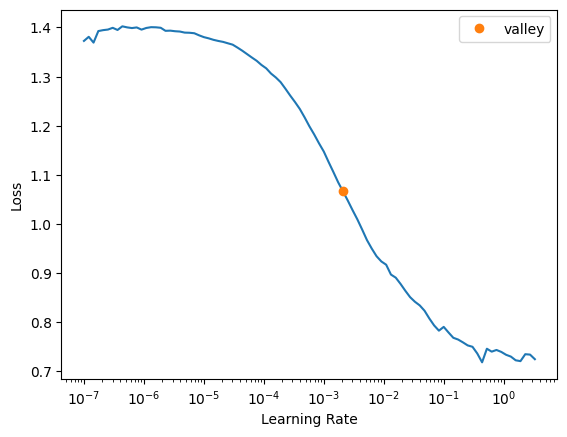

In [10]:
get_train_valid_splits(edf_files[1:6])

In [ ]:
# calculate the TPR 
def TPR(y_true, y_pred):
    # calculate the confusion matrix
    cm = skm.confusion_matrix(y_true, y_pred)
    # calculate the TPR
    TPR = cm[1][1] / (cm[1][1] + cm[1][0])
    return TPR

